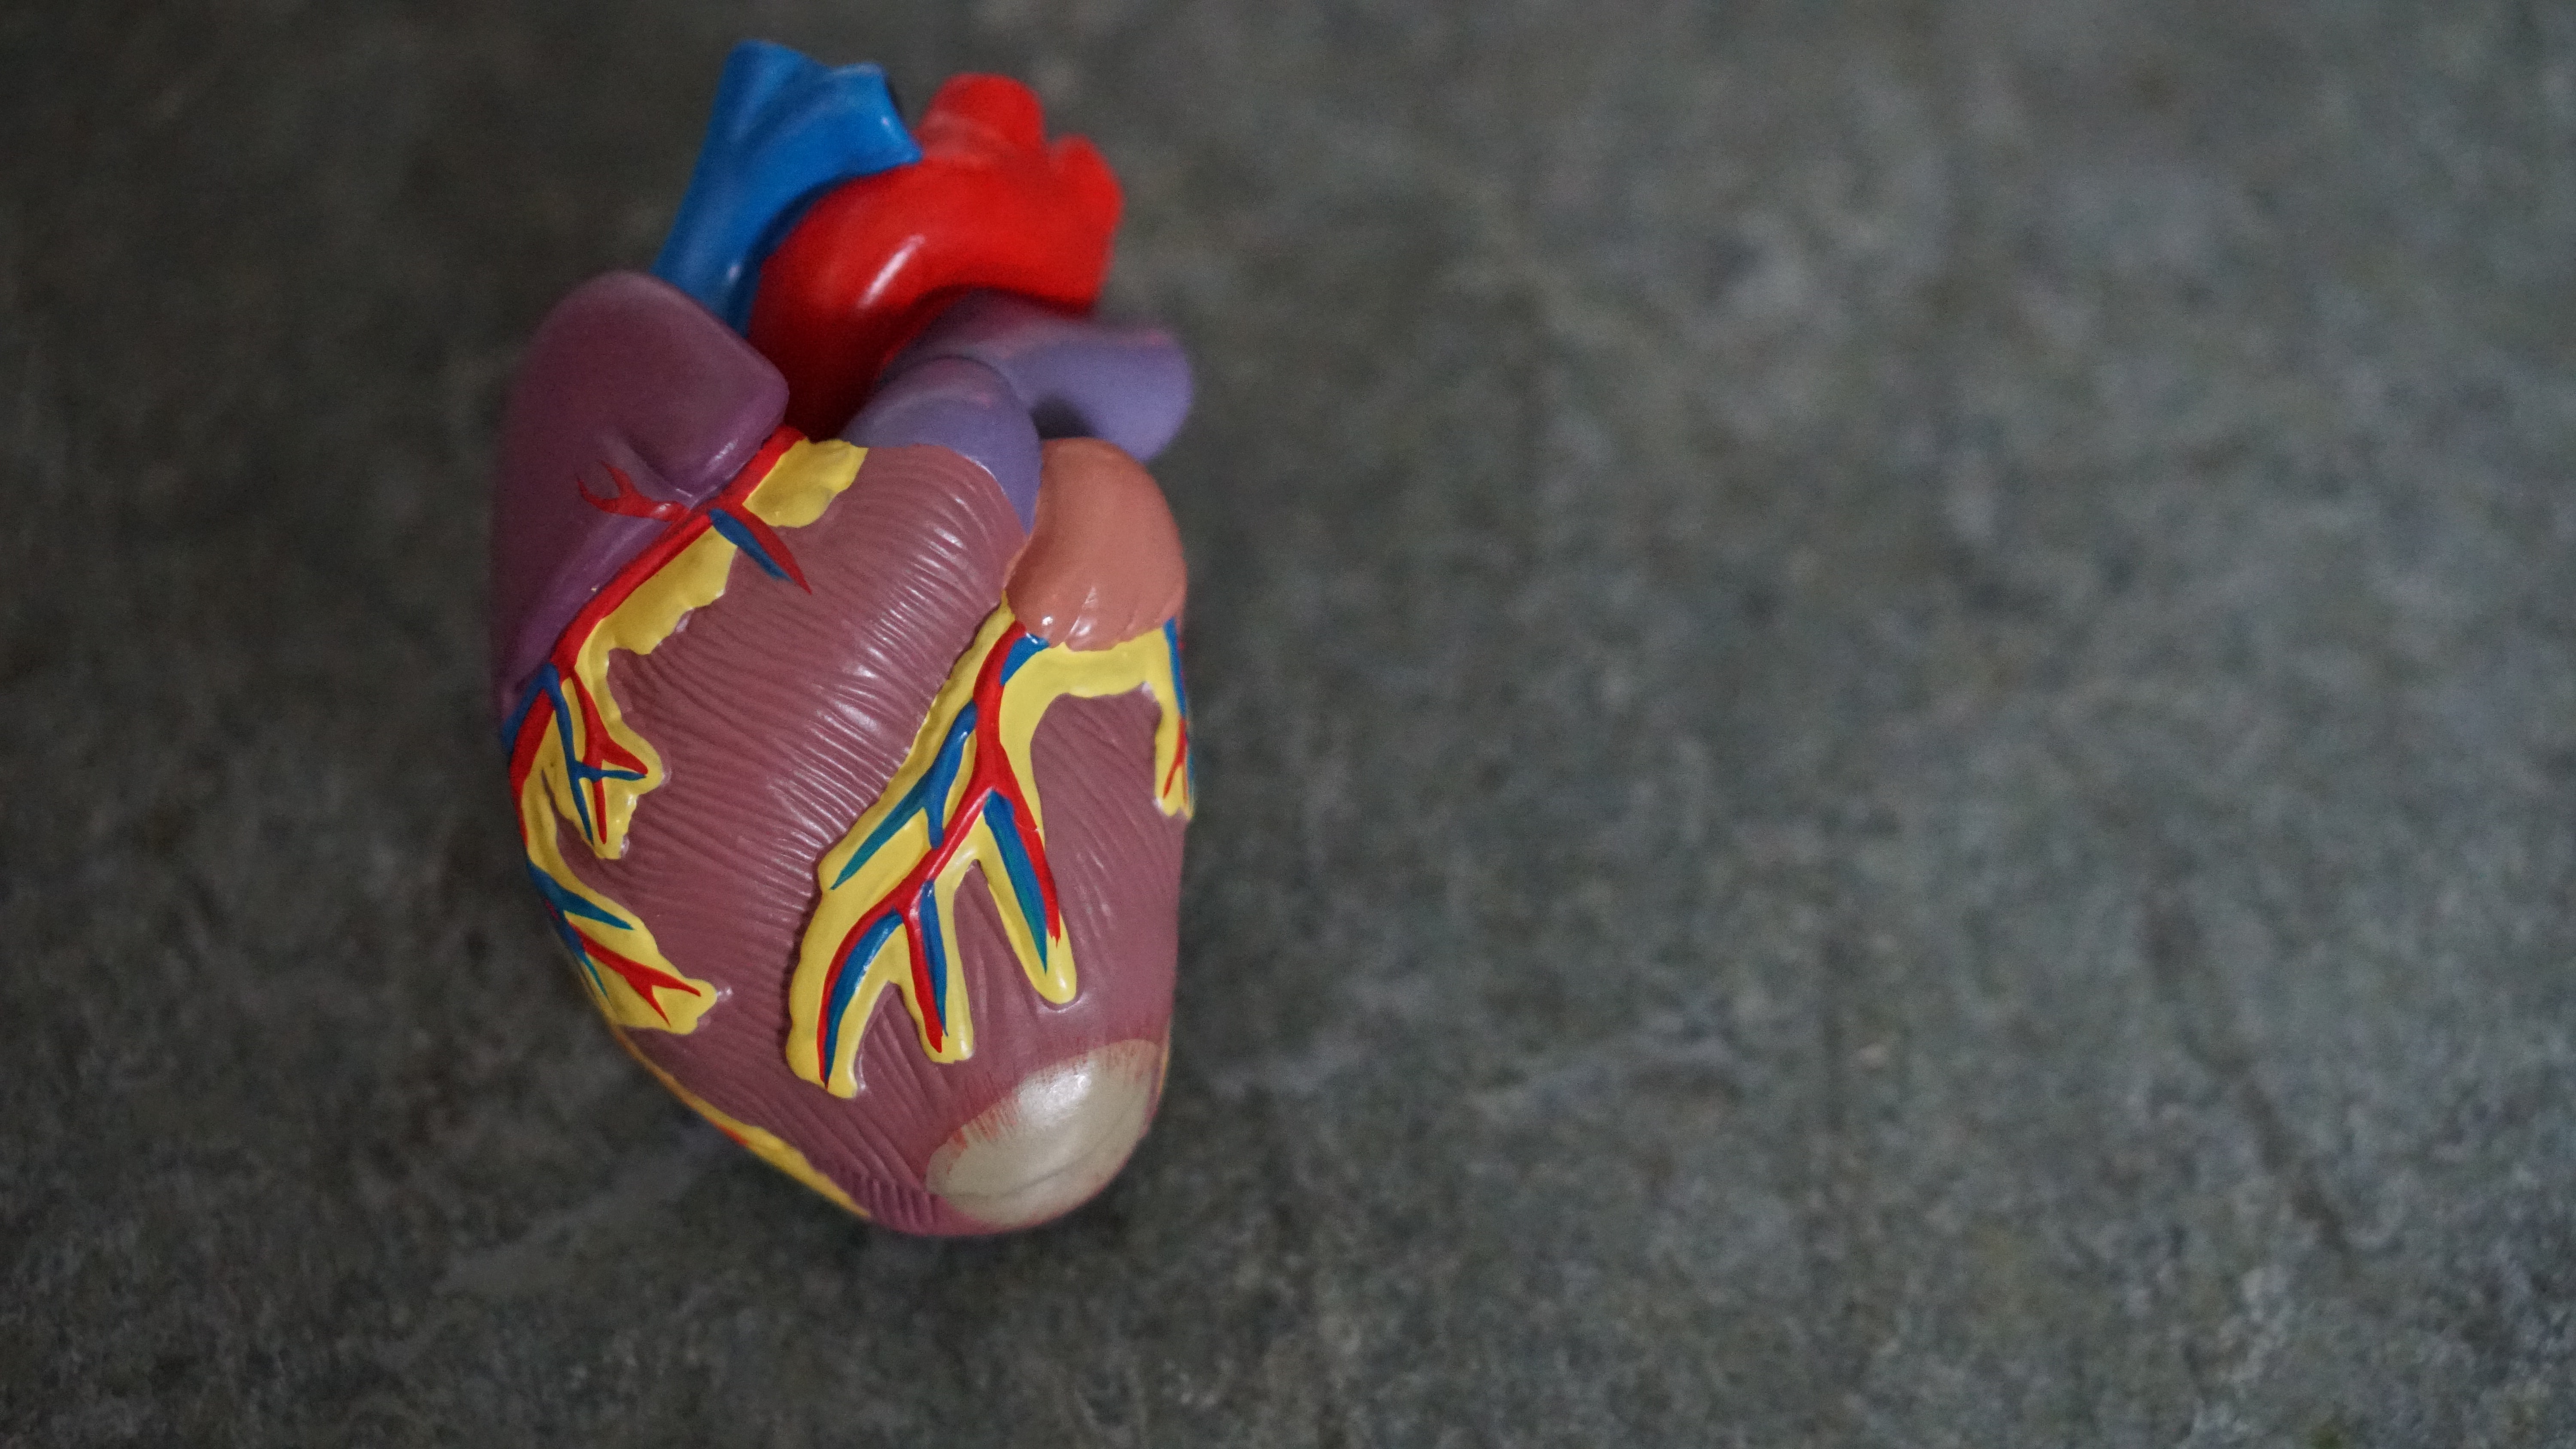

In [1]:
from IPython.display import Image
Image("../data/image/img4.jpg")

# 0.0 Bussines Context

## 0.1 Bussines Problem

Our challenge is to help the **Cadio Catch Diseases** a company that specializes in detecting heart diseases in the early stages. 

Its bussiness model is 'service' it means that company offers an early heart diseases diagnostic for a price.

Importants Details:

- Actually the precision of the diagnostic is between 55% and 65%.
- For each 5% of acuracy over 50% the price is R$ 500,00

**Main Goal:**

Create a tool that increases diagnostic accuracy and that this accuracy is stable for all diagnostics.

**Secundary Goals:**

Answer the CEO questions,

1. What is the Accuracy and Precision of the tool?
2. How much profit will Cardio Catch Diseases have with the new tool?
3. How Reliable is the result given by the new tool?


Business problem reference: https://sejaumdatascientist.com/projeto-de-data-science-diagnostico-precoce-de-doencas-cardiovasculares/

Download the data: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

## 0.2 Cocnclusions and Results

After all procedures and analysis performed the best result that we could get was

**LGBM:**
 - Precision of 0.84
 - Accuracy of 0.75

What gives the answer to the first question of the CEO.

About the profit, .....

# 0.2 Helper Functions and Imports

## 0.2.1 Imports

In [1]:
# General Propose
import shap
import pickle
shap.initjs()
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Hipo Test
from scipy.stats import f_oneway
from scipy.stats import ttest_ind


# Pre-processing
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

# Modelling
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, precision_score
from yellowbrick.classifier.threshold import discrimination_threshold

# Set options and warnings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('MAX_ROWS', None)

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.


## 0.2.2 Helper Functions

In [31]:
# Helper Functions
def balanced_target(target, dataset, hue=None):
    """
    Function to check the balancing of the target variable.

    :target:  An pd.Series of the target variable that will be checked.
    :dataset: An Dataframe object. 
    """
    sns.set(style='darkgrid', palette='Accent')
    ax = sns.countplot(x=target, hue=hue, data=dataset)
    ax.figure.set_size_inches(10, 6)
    ax.set_title('Cardio Distribution', fontsize=18, loc='left')
    ax.set_xlabel(target, fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax=ax


def univariate_analysis(target, df):
    """
    Function to perform univariate analysis.

    df: DataFrame
    """
    for col in df.columns.to_list():

        fig = sns.displot(x=col, hue=target, data=df, kind='hist')
        fig.set_titles(f'{col}\n distribuition', fontsize=16)
        fig.set_axis_labels(col, fontsize=14)


def multi_histogram(data: pd.DataFrame, variables: list) -> None:

    # set of initial plot posistion
    plt.figure(figsize=(18, 10))
    n = 1
    for column in data[variables].columns:
        plt.subplot(3, 3, n)
        _ = sns.histplot(x=data[column], bins=50)
        n += 1

    plt.subplots_adjust(hspace=0.3)

    plt.show()



def multi_boxplot(data: pd.DataFrame, variables: list) -> None:

    """
    Function to check for outliers visually through a boxplot

    data: DataFrame

    variable: list of numerical variables
    """

    # set of initial plot posistion
    plt.figure(figsize=(18, 10))
    n = 1
    for column in data[variables].columns:
        plt.subplot(3, 3, n)
        _ = sns.boxplot(x=column, data=data)
        n += 1

    plt.subplots_adjust(hspace=0.3)

    plt.show()


def hipo_test(*samples):

    samples = samples

    try:
        if len(samples) == 2:
            stat, p = ttest_ind(*samples)
        elif len(samples) > 2:
            stat, p = f_oneway(*samples)
    except:
        raise Exception("Deve ser fornecido pelo menos duas samples!!!")

    if p < 0.05:
        print(f'O valor de p é: {p}')
        print('Provável haver diferença')
    else:
        print(f'O valor de p é: {p}')
        print('Provável que não haja diferença')

    return stat, p


def point_bi_corr(a,b):

    """
    Function to calculate point biserial correlation coefficient heatmap function
    Credits: Bruno Santos - Comunidade DS

    :a: input dataframe with binary variable
    :b: input dataframe with continous variable
    """

    # Get column name
    a = a.values.reshape(-1)
    b = b.columns.reshape(-1)

    # apply scipys point-biserial
    stats.pointbiserialr(a, b)

    # correlation coefficient array
    c = np.corrcoef(a,b)

    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a_name, b_name], index=[a_name, b_name])

    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a_name, b_name));


def change_threshold_lgbm(X, y, model, n_splits, thresh):

    # cross-validação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

    pred_prob = model.predict_proba(X_valid)

    for i in range(0, len(pred_prob)):
        if pred_prob[i, 1] >= thresh:
            pred_prob[i, 1] = 1
        else:
            pred_prob[i, 1] = 0

    print('####### Bussines Metrics #######')
    print('\n')
    acc_inc = accuracy_score(y_valid, pred_prob[:,1]) - 0.50
    prc_inc = round((acc_inc/0.05)*500, 2)
    print(f'Increased precision: {round(acc_inc,2)}')
    print(f'Price Increased in: {prc_inc}')
    print(f'Percentual of Price increassing: {round(prc_inc/500,2)}')
    print('\n')

    # print classification report
    print("Relatório de Classificação:\n",
           classification_report(y_valid, pred_prob[:,1], digits=2))

    return pred_prob[:, 1]


def change_threshold_lr(X, y, model, n_splits, thresh):
    # cross-validação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

    y_scores_final = model.decision_function(X_valid)
    y_pred_recall = (y_scores_final > thresh)

    print('####### Bussines Metrics #######')
    print('\n')
    acc_inc = accuracy_score(y_valid, y_pred_recall) - 0.50
    prc_inc = round((acc_inc/0.05)*500, 2)
    print(f'Increased precision: {round(acc_inc,2)}')
    print(f'Price Increased in: {prc_inc}')
    print(f'Percentual of Price increassing: {round(prc_inc/500,2)}')
    print('\n')

    print('####### Machine Learning Metrics #######')
    print('\n')
    print(f'New accuracy: {accuracy_score(y_valid,y_pred_recall)}')
    print(f'New kappa: {cohen_kappa_score(y_valid,y_pred_recall)}')
    print(f'New precision: {precision_score(y_valid,y_pred_recall)}')

    return y_pred_recall


################################################# Custons Transformers ###########################################################

class PreProcessingTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        Xtemp = X.copy()

        # Height
        index_height = Xtemp.loc[Xtemp['height'] > 230, ['height']].index
        Xtemp.drop(index_height, inplace=True)
        index_height1 = Xtemp.loc[Xtemp['height'] < 112, ['height']].index
        Xtemp.drop(index_height1, inplace=True)

        # Weight
        index_weight = Xtemp.loc[Xtemp['weight'] < 40, ['weight']].index
        Xtemp.drop(index_weight, inplace=True)

        # ap_hi
        index_ap_hi = Xtemp.loc[Xtemp['ap_hi'] < 10, ['ap_hi']].index
        Xtemp.drop(index_ap_hi, inplace=True)

        # ap_lo
        index_ap_lo = Xtemp.loc[Xtemp['ap_lo'] < 5, ['ap_lo']].index
        Xtemp.drop(index_ap_lo, inplace=True)

        return Xtemp


class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        Xtemp = X.copy()

        # Year_age
        Xtemp['year_age'] = Xtemp['age'] / 365

        # drop 'id' and 'age' 'smoke','alco','gluc', 'ap_lo', 'cholesterol', 'height', 'active', 'weight'
        Xtemp.drop(['id', 'age'], inplace=True, axis=1)

        # IMC
        Xtemp['imc'] = Xtemp['weight']/(Xtemp['height']/100)**2

        # cat_dwarfism
        Xtemp['cat_Dwarfism'] = [1 if value < 145 else 0 for value in Xtemp['height']]

        # ap_hi divide 10
        Xtemp.loc[Xtemp['ap_hi'] > 220, ['ap_hi']] = Xtemp.loc[Xtemp['ap_hi'] > 220, ['ap_hi']]/10

        # ap_lo divide 10
        Xtemp.loc[Xtemp['ap_lo'] > 190, ['ap_lo']] = Xtemp.loc[Xtemp['ap_lo'] > 190, ['ap_lo']]/10

        # ap_hi divide 10
        Xtemp.loc[Xtemp['ap_hi'] > 220, ['ap_hi']] = Xtemp.loc[Xtemp['ap_hi'] > 220,['ap_hi']]/10

        # ap_hi divide 10
        Xtemp.loc[Xtemp['ap_hi'] > 220, ['ap_hi']] = Xtemp.loc[Xtemp['ap_hi'] > 220,['ap_hi']]/10

        # ap_lo divide 10
        Xtemp.loc[Xtemp['ap_lo'] > 190, ['ap_lo']] = Xtemp.loc[Xtemp['ap_lo'] > 190,['ap_lo']]/10

        return Xtemp


class CatBloodPressureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        Xtemp = X.copy()

        # cat_bloodpressure
        def cat_bloodpressure(df):

            if df['ap_hi'] < 90 and df['ap_lo'] < 60:
                return 1 #Hipotensão
            elif 90 <= df['ap_hi'] < 140 and 60 <= df['ap_lo'] < 90:
                return 2    # Pré-Hipotensão
            elif 140 <= df['ap_hi'] < 160 and 90 <= df['ap_lo'] < 100:
                return 3  # 'Hipertensão estagio1'
            elif df['ap_hi'] >= 160 and df['ap_lo'] >= 100:
                return 4 # 'Hipertensão estagio2'
            else:
                return 5 # 'no_cat'

        # cat_bloodpressure
        Xtemp['cat_bloodpressure'] = Xtemp.apply(cat_bloodpressure, axis=1)

        return Xtemp


class TotalPressureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):

        return self

    def transform(self, X, y=None):

        Xtemp = X.copy()

        # total_preassure
        Xtemp['total_pressure'] = Xtemp['ap_hi'] + Xtemp['ap_lo']

        return Xtemp


class MyRobustScalerTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        Xtemp = X.copy()

        scaler = RobustScaler()
        Xscaled = scaler.fit_transform(Xtemp)
        Xtemp = pd.DataFrame(Xscaled, columns=Xtemp.columns.to_list())

        return Xtemp

# 1.0 Collect Data

In [3]:
train = pd.read_csv('../data/raw/cardio_train.csv', sep=';')
print(f'The number of columns are {train.shape[1]}')
print(f'The number of rows are {train.shape[0]}')

The number of columns are 13
The number of rows are 70000


# 2.0 Data Description

Takeways:

- Variable age are in days. Lets divide it for 365 and check if the values make sense.
- We will drop 'id' in some point because doesnt give us much infomation.
- No need to encoding categorical variables.
- Binary classification problem.
- Lets consider the possibility os OHE the categorical variables to.

In [6]:
# Sneak look
train.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [7]:
# Details of the data
pd.DataFrame({'missingPerc': train.isna().mean(),
              'uniques': train.nunique(),
              '%uniquePerc': round((train.nunique()/train.shape[0])*100, 2),
              'data_types': train.dtypes,
              'mean': round(train.mean(), 2),
              'median': round(train.median(), 2),
              'std': round(train.std(), 2),
              'min': round(train.min(), 2),
              'max': round(train.max(), 2)})

missingPerc  uniques  %uniquePerc data_types      mean   median  \
id                   0.0    70000       100.00      int64  49972.42  50001.5   
age                  0.0     8076        11.54      int64  19468.87  19703.0   
gender               0.0        2         0.00      int64      1.35      1.0   
height               0.0      109         0.16      int64    164.36    165.0   
weight               0.0      287         0.41    float64     74.21     72.0   
ap_hi                0.0      153         0.22      int64    128.82    120.0   
ap_lo                0.0      157         0.22      int64     96.63     80.0   
cholesterol          0.0        3         0.00      int64      1.37      1.0   
gluc                 0.0        3         0.00      int64      1.23      1.0   
smoke                0.0        2         0.00      int64      0.09      0.0   
alco                 0.0        2         0.00      int64      0.05      0.0   
active               0.0        2         0.00      int64      0.80      1.0   
cardio               0.0        2         0.00      int64      0.50      0.0   

                  std      min      max  
id           28851.30      0.0  99999.0  
age           2467.25  10798.0  23713.0  
gender           0.48      1.0      2.0  
height           8.21     55.0    250.0  
weight          14.40     10.0    200.0  
ap_hi          154.01   -150.0  16020.0  
ap_lo          188.47    -70.0  11000.0  
cholesterol      0.68      1.0      3.0  
gluc             0.57      1.0      3.0  
smoke            0.28      0.0      1.0  
alco             0.23      0.0      1.0  
active           0.40      0.0      1.0  
cardio           0.50      0.0      1.0

# 3.0 Spliting Data

## 3.1 Split Data

Our Split strategy is get 60000 observations to train de models using cross-validation and get 10000 observations to the parametrs tunning.

In [5]:
# training data and Validanting data
dfTrain = train[:60000]
dfValid = train[60000:]

# splitting data
X = dfValid.drop(['cardio'], axis=1)
y = dfValid['cardio']

# 4.0 EDA

## 4.1 Univariate Analysis

Main takeways:

- Our target is balanced with 35000 observations for each class.
- 'age' and 'weight'(as they increases) seems to have more influence over 'cardio'
- We do have outliers!!!

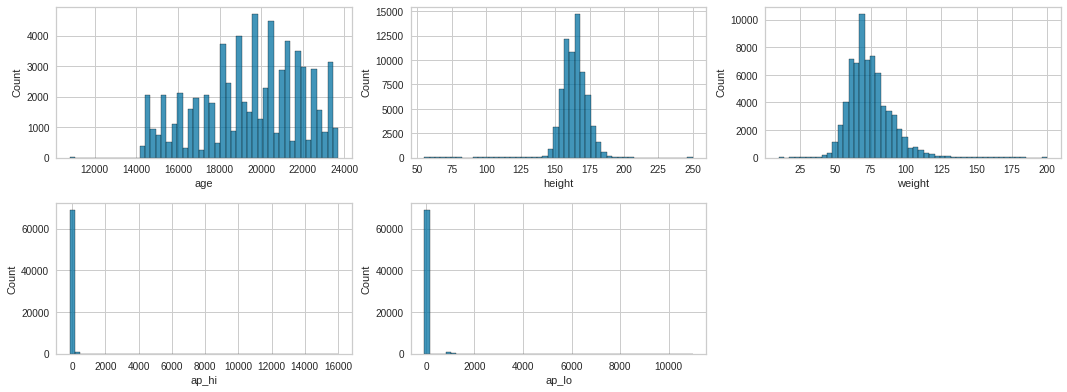

In [95]:
# Checking all numerical vars
numerical_vars = ['age','height', 'weight', 'ap_hi', 'ap_lo']
multi_histogram(data=train, variables=numerical_vars)

### 4.1.1 'cardio' analysis

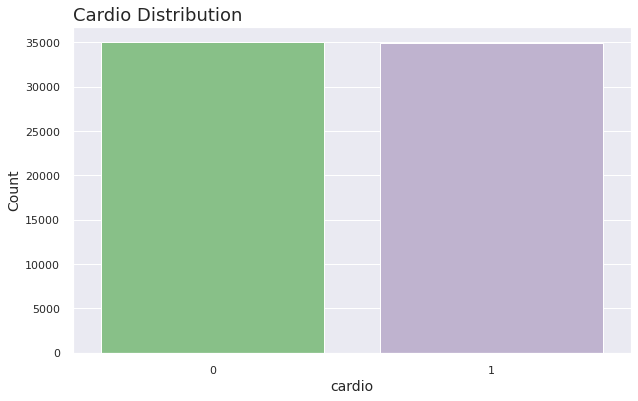

In [102]:
# Target Analysys
balanced_target(target='cardio',dataset=train)

### 4.1.2 'Age'

 - Looks like the count of heart diseases increases with 'Age'.

count    70000.000000
mean        53.339358
std          6.759594
min         29.583562
25%         48.394521
50%         53.980822
75%         58.430137
max         64.967123
Name: age_years, dtype: float64




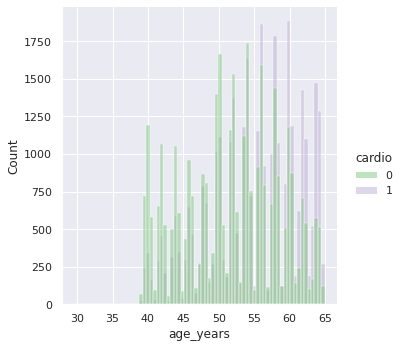

In [9]:
# changing the variable 'Age' to years instead of days
age_df = train.copy()
age_df['age_years'] = age_df['age'] / 365

print(age_df['age_years'].describe())
print('\n')

# Plot distribution
fig = sns.displot(x=age_df['age_years'], hue=age_df['cardio'], data=age_df, kind='hist')

### 4.1.3 'Height'

- The distribution to class 0 an 1 are very similar.
- We found a value of 250 each is impossible to happen in real world, so we will replace its value for 207 (the highest possible value).
- There is small values like 55cm. Dwarfism is related to a lower expectancy of life usually due cardiovascular diseases having it in mind we will create a new binary variable 1 - for cases where height is lower than 1,45 and 0 when its not the case. We will also drop the cases where the Height is less than 112 because this data points are probably a error. The height of dwarf people ususally varies between 112 and 145.

count    70000.000000
mean       164.359229
std          8.210126
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64




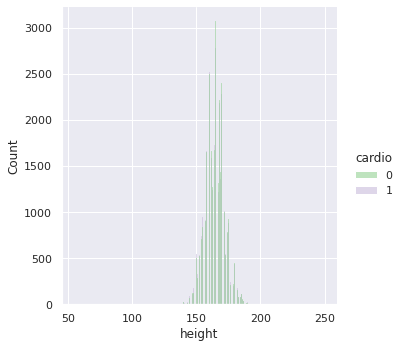

In [10]:
# Describe
print(train['height'].describe())
print('\n')

# Plot distribution
fig = sns.displot(x=train['height'], hue=train['cardio'], data=train, kind='hist')

### 4.1.4 'weight'

- Looks like higher weigt leads to more cases of heart diseases. 
- Drop the weights bellow 40. Because they are to small and are probably due to some error.


count    70000.000000
mean        74.205690
std         14.395757
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64




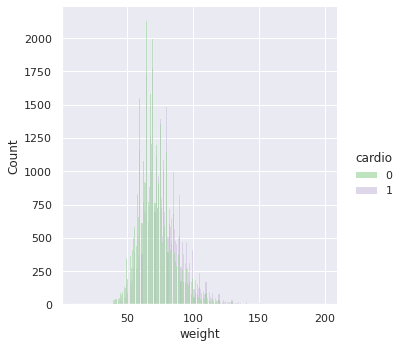

In [11]:
# Describe
print(train['weight'].describe())
print('\n')

# Plot distribution
fig = sns.displot(x=train['weight'], hue=train['cardio'], data=train, kind='hist')

### 4.1.4 'ap_hi'

Researching little be about the suject on internet, is unusual Systolic blood preassure below 10 and above 220.
- We have 130 observations below 10 and 624 observations over 220 which is unusual. Lets drop them.

In [36]:
# count below 10 values
train.loc[train['ap_hi']<10,:].size

130

In [9]:
# count values over 220
train.loc[train['ap_hi']>220,:].size

624

count    69942.000000
mean       126.698336
std         17.979907
min         10.000000
25%        120.000000
50%        120.000000
75%        140.000000
max        220.000000
Name: ap_hi, dtype: float64




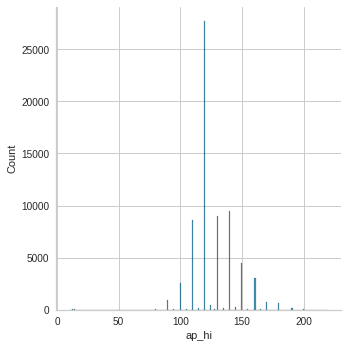

In [38]:
# Dropping
df = train.copy()
index = df.loc[(df['ap_hi']<10)|(df['ap_hi']>220),['ap_hi']].index
df.drop(index, inplace=True)

# Describe
print(df['ap_hi'].describe())
print('\n')

# Plot distribution
fig = sns.displot(x=df['ap_hi'], data=df, kind='hist')

### 4.1.5 'ap_lo'

Researching little be about the suject on internet, is unusual Diastolic blood preassure below 5 and divide values over 190 by 10. 

The former is because probably this numbers are type-error.For exemple 190.00 blood preassure can be typed as 19000.

- Lets drop the values below 10.
- Lets divide the values over 190 by 10.

count    69024.000000
mean        81.351008
std          9.801631
min          6.000000
25%         80.000000
50%         80.000000
75%         90.000000
max        190.000000
Name: ap_lo, dtype: float64




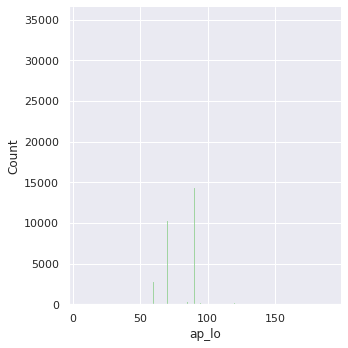

In [14]:
# Dropping
df = train.copy()
index = df.loc[(df['ap_lo']<5)|(df['ap_lo']>190),['ap_lo']].index
df.drop(index, inplace=True)

# Describe
print(df['ap_lo'].describe())
print('\n')

# Plot distribution
fig = sns.displot(x=df['ap_lo'], data=df, kind='hist')

### 4.2 Checking Outliers

We do have a lot of outliers.

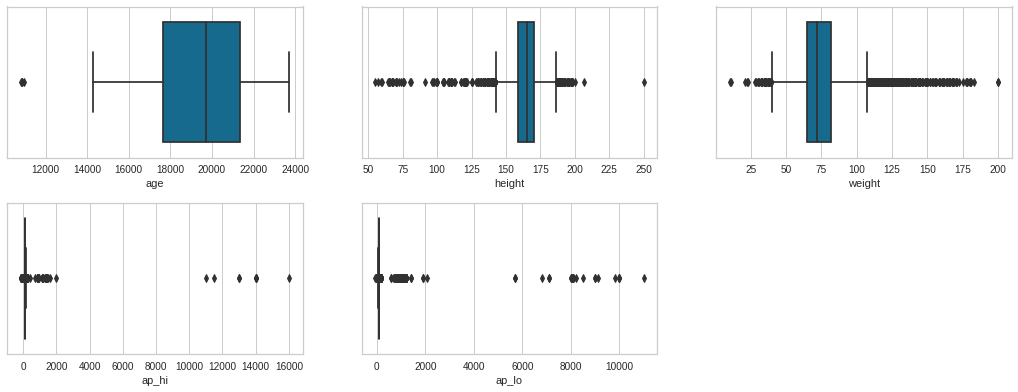

In [85]:
out_train = train.drop(['id','gender','gluc','smoke','cholesterol','active','alco','cardio'],axis=1)
vars = out_train.columns.to_list()

multi_boxplot(data=train, variables=vars)

## 4.2 Bivariate Analysis

- Lets work with just numerical variables.
- By the 'age' vs 'weight' plot we can see that the incidence of event 1 increases as age and weight increase as well.
- The variable 'height' seems to have little influence on our positive event.
- By the 'ap_hi' and 'ap_lo' we can see the presence of some outliers.

In [16]:
# Set of Variables
bi_train = train.drop(['id','gender','gluc','smoke','cholesterol','active','alco'],axis=1)

### 4.2.1 'age' vs 'weight'

<AxesSubplot:xlabel='age', ylabel='weight'>

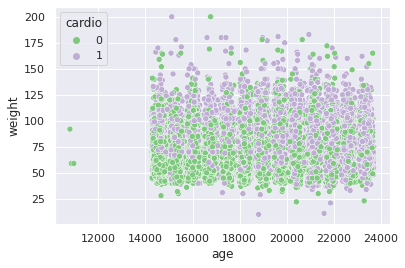

In [17]:
# 'age' vs 'weight'
sns.scatterplot(x='age',y='weight',hue='cardio',data=bi_train)

### 4.2.2 'age' vs 'height'

<AxesSubplot:xlabel='age', ylabel='height'>

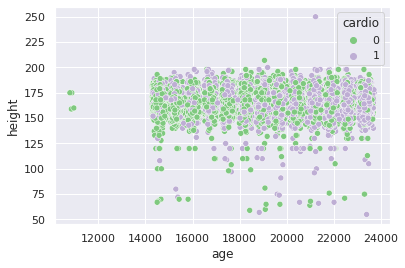

In [18]:
# 'age' vs 'height'
sns.scatterplot(x='age',y='height',hue='cardio',data=bi_train)

### 4.2.3 'age' vs 'ap_lo'

<AxesSubplot:xlabel='age', ylabel='ap_lo'>

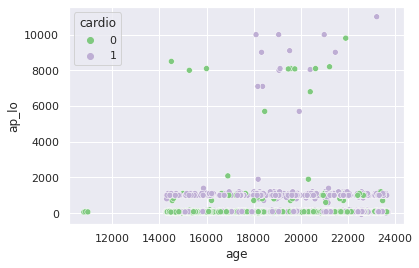

In [19]:
sns.scatterplot(x='age',y='ap_lo',hue='cardio',data=bi_train)

### 4.2.4 'age' vs 'ap_hi'

<AxesSubplot:xlabel='age', ylabel='ap_hi'>

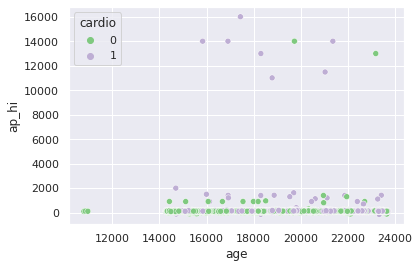

In [20]:
sns.scatterplot(x='age',y='ap_hi',hue='cardio',data=bi_train)

### 4.2.5 cardio vs categoricals

- It seems that our target variable distribution is following the distribuition of the categorical variable.
  Ex. 'cholesterol' in our dataset there is a more number of 1-normal thats why there is a concentrecion of 'cardio' events in this category.

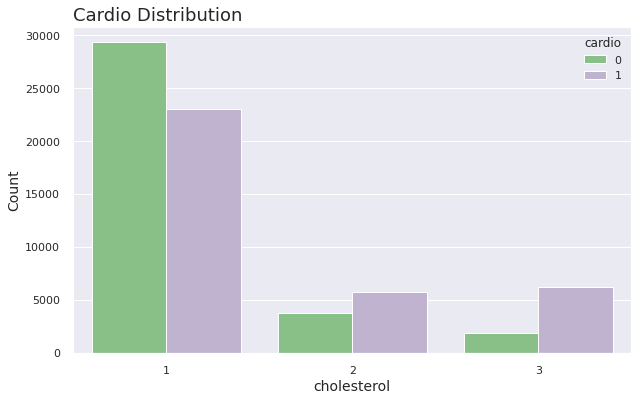

In [97]:
# cardio distribution by 'cholesterol'
balanced_target(target='cholesterol',hue='cardio', dataset=train)

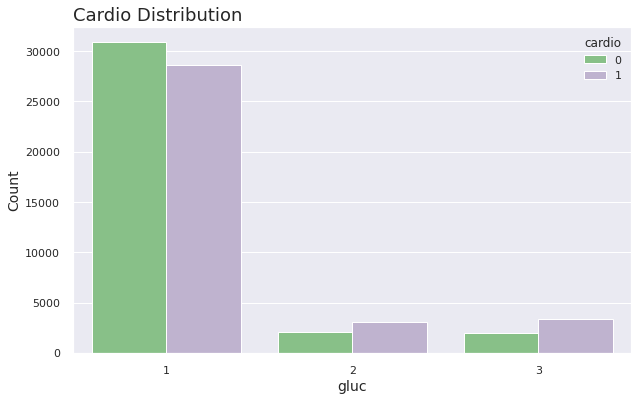

In [98]:
# cardio distribution by 'gluc'
balanced_target(target='gluc',hue='cardio', dataset=train)

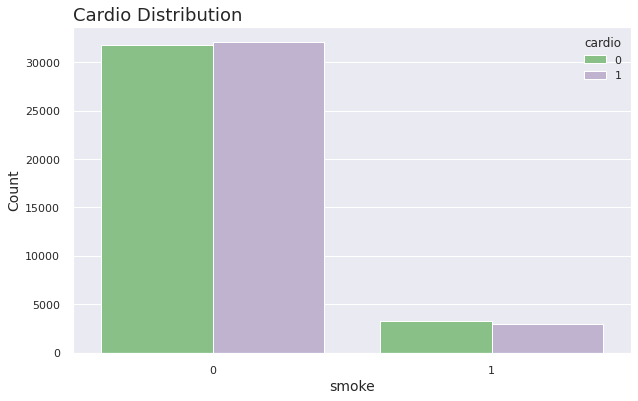

In [99]:
# cardio distribution by 'smoke'
balanced_target(target='smoke',hue='cardio', dataset=train)

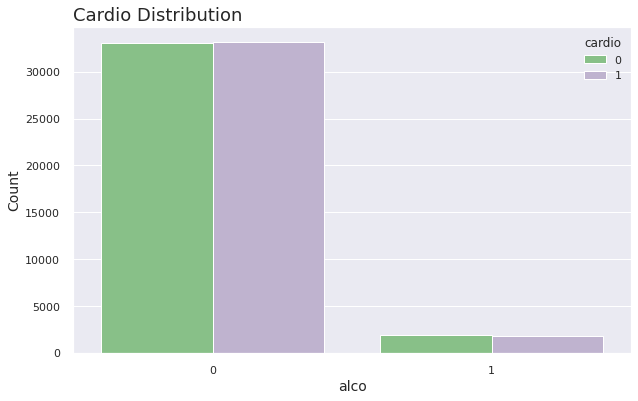

In [100]:
# cardio distribution by 'alco'
balanced_target(target='alco',hue='cardio', dataset=train)

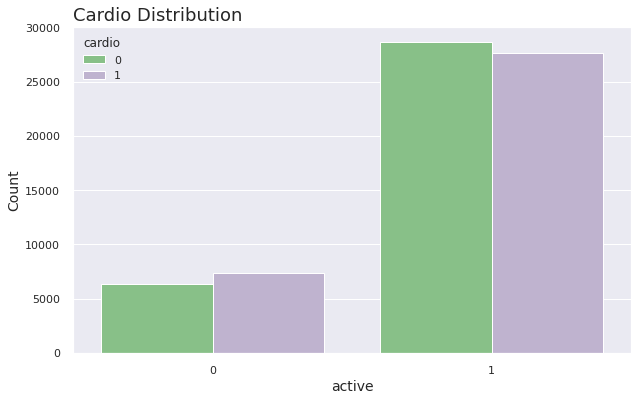

In [101]:
# cardio distribution by 'active'
balanced_target(target='active',hue='cardio', dataset=train)

# 5.0 Hypothesis Test

1.0 Does the 'age' affect the number of cases of cardiovascular disease?

2.0 Does the 'weight' affect the number of cases of cardiovascular disease?

3.0 Does the 'height' affect the number of cases of cardiovascular disease?

#### 5.1 Does the 'age' affect the number of cases of cardiovascular disease?
Conclusion p-value less than 0.05 there is probably a diference, since the mean of class 1 is higher the variable 'age' has impact over the target.

In [52]:
sample_class0 = train.loc[train['cardio']==0,'age']
sample_class1 = train.loc[train['cardio']==1,'age']

print(f'The Mean to class 0: {np.mean(sample_class0)}')
print(f'The Mean to class 1: {np.mean(sample_class1)}')
print('\n')

# Testing the Hypothesis
hipo_test(sample_class0, sample_class1)

The Mean to class 0: 18881.623711487395
The Mean to class 1: 20056.81303067555


O valor de p é: 0.0
Provável haver diferença


(-64.87686765829967, 0.0)

#### 5.2 Does the 'weight' affect the number of cases of cardiovascular disease?
Conclusion p-value less than 0.05 there is probably a diference, since the mean of class 1 is higher the variable 'weight' has impact over the target.

In [53]:
sample_class0 = train.loc[train['cardio']==0,'weight']
sample_class1 = train.loc[train['cardio']==1,'weight']

print(f'The Mean to class 0: {np.mean(sample_class0)}')
print(f'The Mean to class 1: {np.mean(sample_class1)}')
print('\n')

# Testing the Hypothesis
hipo_test(sample_class0, sample_class1)

The Mean to class 0: 71.5921504240313
The Mean to class 1: 76.82236770633808


O valor de p é: 0.0
Provável haver diferença


(-48.8751254371945, 0.0)

#### 5.3 Does the 'height' affect the number of cases of cardiovascular disease?
Conclusion p-value less than 0.05 there is probably a diference, since the mean of class 0 is higher the variable 'height' has a little impact the predictions of class 1. 

In [56]:
sample_class0 = train.loc[train['cardio']==0,'height']
sample_class1 = train.loc[train['cardio']==1,'height']

print(f'The Mean to class 0: {np.mean(sample_class0)}')
print(f'The Mean to class 1: {np.mean(sample_class1)}')
print('\n')

# Testing the Hypothesis
hipo_test(sample_class0, sample_class1)

The Mean to class 0: 164.44801690414323
The Mean to class 1: 164.2703336287487


O valor de p é: 0.004196298813631695
Provável haver diferença


(2.863109659842556, 0.004196298813631695)

# 6.0 Pre-Processing / FeatureEngineering

### During the Pre-Processing - Feature Engineering step we perform the actions below
##### obs: The code are in the Helpers Function section of this notebook, it was done trough custom transformers

-  We created a age variable in years.
-  We droped all observations of 'height' with more than 230
-  We droped al observations of 'height' with less than 112
-  We created the cat_dwarfism variable - if the 'height' is less than 145 its class 1 otherwise its 0.
-  We created a 'IMC' variable.
-  We droped the 'weight' below 40.
-  We droped the 'ap_hi' negativos.
-  We divided the 'ap_hi' over 220 by 10 three times. It was necessary due extreme high values
-  We divided the 'ap_lo' over 190 by 10 two times. It was necessary due extreme high values

# 6.1 Testing Pipeline

- Everything looks fine!!!

In [14]:
pipeline = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                           ('totalpress', TotalPressureTransformer()),
                           ('catpress', CatBloodPressureTransformer())
                           ])

ct = ColumnTransformer([('numerical',MyRobustScalerTransformer(), ['age','height','weight', 'ap_hi', 'ap_lo','total_pressure', 'imc']),
                       ('categorical',OneHotEncoder(drop='first'), ['cholesterol', 'gluc', 'active', 'gender', 'smoke', 'alco','cat_bloodpressure','cat_Dwarfism'])])


pipeline_final = Pipeline(steps= [('geral',pipeline),
                                  ('num_cat', ct)])

exemp = pipeline_final.fit_transform(dfTrain)
pd.DataFrame(exemp).head()

0         1         2    3    4    5         6    7    8    9    10  \
0 -0.357883  0.272727 -0.588235 -0.5  0.0 -0.5 -0.698518  0.0  0.0  0.0  0.0   
1  0.142662 -0.818182  0.764706  1.0  1.0  1.5  1.353997  0.0  1.0  0.0  0.0   
2 -0.231315  0.000000 -0.470588  0.5 -1.0  0.0 -0.454526  0.0  1.0  0.0  0.0   
3 -0.567921  0.363636  0.588235  1.5  2.0  2.5  0.369402  0.0  0.0  0.0  0.0   
4 -0.608565 -0.818182 -0.941176 -1.0 -2.0 -2.0 -0.533175  0.0  0.0  0.0  0.0   

    11   12   13   14   15   16   17   18   19  
0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  
1  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  
3  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
4  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0

# 7.0 Machine Learning Modelling

We choose to deploy the LightGBM model the main reason is because it had the best performance.

When the threshold was 0.60 we cloud achieve a precision of 84% with global accuracy of 75%, after the tunning of hyperparameters we retrained the model with all the data and deploy it as  an API.

## 7.1 LogisticRegression Pipeline

In [10]:
# Training Model
def train_LR(X, n_iter, n_splits=10):

    print('> Iniciando Treinamento...')

    cleaning_pipeline = Pipeline(steps=[('preproc', PreProcessingTransformer())])

    pipeline = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                               ('totalpress', TotalPressureTransformer()),
                               ('catpress', CatBloodPressureTransformer())
                               ])

    ct = ColumnTransformer([('numerical',MyRobustScalerTransformer(), ['height','weight', 'ap_hi', 'ap_lo', 'imc', 'total_pressure']),
                           ('categorical',OneHotEncoder(drop='first'), ['gender','cholesterol', 'gluc', 'smoke', 'alco', 'active','cat_bloodpressure','cat_Dwarfism'])])


    pipeline_final = Pipeline(steps= [('geral',pipeline),
                                      ('num_cat', ct),
                                      ('model', LogisticRegression(C=0.5, n_jobs=-1))])


    data = cleaning_pipeline.fit_transform(X)
    X = data.drop(['cardio'], axis=1)
    y = data['cardio']


    # Fit the random search model
    print('> Fitting Modelo...')

    # cross-validação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2)

    acc = []
    kappa = []
    precision = []
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]


        pipeline_final.fit(X_treino, y_treino)
        pred = pipeline_final.predict(X_valid)
        accuracy = accuracy_score(y_valid, pred)
        Kappa =  cohen_kappa_score(y_valid, pred)
        Precision = precision_score(y_valid, pred)
        acc.append(accuracy)
        kappa.append(Kappa)
        precision.append(Precision)

    print('####### Bussines Metrics #######')

    print('\n')
    acc_inc = np.mean(acc) - 0.50
    prc_inc = round((acc_inc/0.05)*500, 2)
    print(f'Increased accuracy: {round(acc_inc,2)}')
    print(f'Price Increased in: {prc_inc}')
    print(f'Percentual of Price increassing: {round((prc_inc/500),2)}')
    print('\n')

    print('####### Machine Learning Metrics #######')
    print(f'Accuracy médio: {np.mean(acc)}')
    print(f'Accuracy Desvio Padrão: {np.std(acc)}')

    print('\n')

    print(f'kappa médio: {np.mean(kappa)}')
    print(f'kappa Desvio Padrão: {np.std(kappa)}')

    print('\n')

    print(f'Precision médio: {np.mean(precision)}')
    print(f'Precision Desvio Padrão: {np.std(precision)}')


    print('> Treinamento realizado...')
    return pipeline_final

model_lr = train_LR(X=dfTrain, n_iter=5)

> Iniciando Treinamento...
> Fitting Modelo...
####### Bussines Metrics #######


Increased accuracy: 0.22
Price Increased in: 2222.42
Percentual of Price increassing: 4.44


####### Machine Learning Metrics #######
Accuracy médio: 0.7222417813865613
Accuracy Desvio Padrão: 0.0037580800222177875


kappa médio: 0.4443362751534653
kappa Desvio Padrão: 0.007523411300410691


Precision médio: 0.773875816623236
Precision Desvio Padrão: 0.003997408159805111
> Treinamento realizado...


In [49]:
# Checking the generalization, this is not necessary because we are performing cross-validation before but why not an extra care.

pred = model_lr.predict(X)
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.70      0.80      0.74      4965
           1       0.77      0.65      0.71      5035

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



### 7.1.1 Changing the Threshold

With a threshold of 0.70 we can get a new precision of 0.82 with accuracy of 0.70.

That means that our model will guess the positive event right 82% of the time kepping a global accuracy of 0.70.

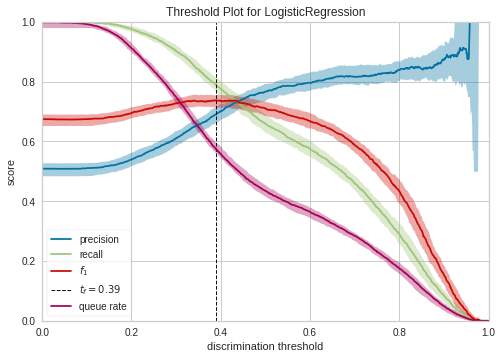

DiscriminationThreshold(ax=<AxesSubplot:title={'center':'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>,
                        force_model=None, model=None)

In [21]:
# Discrimination_threshold
discrimination_threshold(model_lr, X, y)

In [36]:
# Changing the Threshold
new_predictions = change_threshold_lr(X=X, y=y, model=model_lr, n_splits=10, thresh=0.7)

####### Bussines Metrics #######


Increased precision: 0.2
Price Increased in: 1990.0
Percentual of Price increassing: 3.98


####### Machine Learning Metrics #######


New accuracy: 0.699
New kappa: 0.3998341069691025
New precision: 0.8284789644012945


## 7.2 RandomForest Pipeline

In [12]:
# Training Model
def train_RF(X, n_iter, n_splits=10):

    print('> Iniciando Treinamento...')

    cleaning_pipeline = Pipeline(steps=[('preproc', PreProcessingTransformer())])

    pipeline = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                               ('totalpress', TotalPressureTransformer()),
                               ('catpress', CatBloodPressureTransformer())
                               ])

    ct = ColumnTransformer([('numerical',MyRobustScalerTransformer(), ['height','weight', 'ap_hi', 'ap_lo', 'imc', 'total_pressure']),
                           ('categorical',OneHotEncoder(drop='first'), ['gender','cholesterol', 'gluc', 'smoke', 'alco', 'active','cat_bloodpressure','cat_Dwarfism'])])


    pipeline_final = Pipeline(steps= [('geral',pipeline),
                                      ('num_cat', ct),
                                      ('model', RandomForestClassifier(n_jobs=-1))])


    data = cleaning_pipeline.fit_transform(X)
    X = data.drop(['cardio'], axis=1)
    y = data['cardio']


    # Fit the random search model
    print('> Fitting Modelo...')

    # cross-validação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    acc = []
    kappa = []
    precision = []
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        pipeline_final.fit(X_treino, y_treino)
        pred = pipeline_final.predict(X_valid)
        accuracy = accuracy_score(y_valid, pred)
        Kappa =  cohen_kappa_score(y_valid, pred)
        Precision = precision_score(y_valid, pred)
        acc.append(accuracy)
        kappa.append(Kappa)
        precision.append(Precision)

    print('####### Bussines Metrics #######')

    print('\n')
    acc_inc = np.mean(acc) - 0.50
    prc_inc = round((acc_inc/0.05)*500, 2)
    print(f'Increased accuracy: {round(acc_inc,2)}')
    print(f'Price Increased in: {prc_inc}')
    print(f'Percentual of Price increassing: {round((prc_inc/500),2)}')
    print('\n')

    print('####### Machine Learning Metrics #######')
    print(f'Accuracy médio: {np.mean(acc)}')
    print(f'Accuracy Desvio Padrão: {np.std(acc)}')

    print('\n')

    print(f'kappa médio: {np.mean(kappa)}')
    print(f'kappa Desvio Padrão: {np.std(kappa)}')

    print('\n')

    print(f'Precision médio: {np.mean(precision)}')
    print(f'Precision Desvio Padrão: {np.std(precision)}')

    return pipeline_final

model_rf = train_RF(X=dfTrain, n_iter=5)

> Iniciando Treinamento...
> Fitting Modelo...
####### Bussines Metrics #######


Increased accuracy: 0.2
Price Increased in: 1955.56
Percentual of Price increassing: 3.91


####### Machine Learning Metrics #######
Accuracy médio: 0.6955562653107183
Accuracy Desvio Padrão: 0.007443972499634348


kappa médio: 0.39104073893490315
kappa Desvio Padrão: 0.014896098953083687


Precision médio: 0.7128858395598439
Precision Desvio Padrão: 0.0066629216835136515


In [35]:
# Checking the generalization, this is not necessary because we are performing cross-validation before but why not an extra care.
pred = model_rf.predict(X)
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70      4965
           1       0.71      0.66      0.68      5035

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000



## 7.3 LightGBM Pipeline

In [16]:
# Training LGBM
def train_lightGBM(X, n_iter, n_splits=10):


    print('> Iniciando Treinamento...')

    cleaning_pipeline = Pipeline(steps=[('preproc', PreProcessingTransformer())])

    pipeline = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                               ('totalpress', TotalPressureTransformer()),
                               ('catpress', CatBloodPressureTransformer())
                               ])

    ct = ColumnTransformer([('numerical',MyRobustScalerTransformer(), ['height','weight', 'ap_hi', 'ap_lo', 'imc', 'total_pressure']),
                           ('categorical',OneHotEncoder(drop='first'), ['gender','cholesterol', 'gluc', 'smoke', 'alco', 'active','cat_bloodpressure','cat_Dwarfism'])])


    pipeline_final = Pipeline(steps= [('geral',pipeline),
                                      ('num_cat', ct),
                                      ('model', lgb.LGBMClassifier())])


    data = cleaning_pipeline.fit_transform(X)
    X = data.drop(['cardio'], axis=1)
    y = data['cardio']


    # Fit the model
    print('> Fitting Modelo...')

    # cross-validação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    acc = []
    kappa = []
    precision = []
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        pipeline_final.fit(X_treino, y_treino)
        pred = pipeline_final.predict(X_valid)
        accuracy = accuracy_score(y_valid, pred)
        Kappa =  cohen_kappa_score(y_valid, pred)
        Precision = precision_score(y_valid, pred)
        acc.append(accuracy)
        kappa.append(Kappa)
        precision.append(Precision)

    # Dumping the pipeline
    with open('../models/lgbm_pipe.pkl', 'wb') as f:
        pickle.dump(pipeline_final, f)

    print('####### Bussines Metrics #######')

    print('\n')
    acc_inc = np.mean(acc) - 0.50
    prc_inc = round((acc_inc/0.05)*500, 2)
    print(f'Increased accuracy: {round(acc_inc,2)}')
    print(f'Price Increased in: {prc_inc}')
    print(f'Percentual of Price increassing: {round((prc_inc/500),2)}')
    print('\n')

    print('####### Machine Learning Metrics #######')
    print(f'Accuracy médio: {np.mean(acc)}')
    print(f'Accuracy Desvio Padrão: {np.std(acc)}')

    print('\n')

    print(f'kappa médio: {np.mean(kappa)}')
    print(f'kappa Desvio Padrão: {np.std(kappa)}')

    print('\n')

    print(f'Precision médio: {np.mean(precision)}')
    print(f'Precision Desvio Padrão: {np.std(precision)}')

    return pipeline_final

model_lgbm = train_lightGBM(X=dfTrain, n_iter=5)

> Iniciando Treinamento...
> Fitting Modelo...
####### Bussines Metrics #######


Increased accuracy: 0.23
Price Increased in: 2295.06
Percentual of Price increassing: 4.59


####### Machine Learning Metrics #######
Accuracy médio: 0.7295057388110667
Accuracy Desvio Padrão: 0.005638516043878042


kappa médio: 0.4588981058005436
kappa Desvio Padrão: 0.011277529503537085


Precision médio: 0.7695545133453837
Precision Desvio Padrão: 0.00922248621957102


### 7.3.1 - Tunning the Hyperparameters

In [18]:
# Tunnig Parameters - GridSearch

from sklearn.model_selection import GridSearchCV

model = pickle.load(open('../models/lgbm_pipe.pkl', 'rb'))


param_grid = {'learning_rate': [0.0001, 0.1, 1],
              'n_estimators': [100, 500, 1000],
              'num_leaves': [10, 31, 50],
              'min_child_samples' : [10, 20, 30]
             }


def tunnig_gridsearch(X, model, param_grid, cv, scoring, refit):

    """
    Função para tunnig de parâmetros utilizando o GridSearchCV

    """


    cleaning_pipeline = Pipeline(steps=[('preproc', PreProcessingTransformer())])

    data = cleaning_pipeline.fit_transform(X)
    X_ = data.drop(['cardio'], axis=1)
    y_ = data['cardio']

    search = GridSearchCV(estimator=model.named_steps['model'],
                          param_grid=param_grid,
                          scoring=scoring,
                          refit=refit,
                          cv=cv,
                          verbose=1,
                          n_jobs=-1,
                          return_train_score=True)
    search.fit(X_, y_)

    # Dumping the pipe
    with open('../models/lgbm_pipe_tunning.pkl', 'wb') as f:
         pickle.dump(search, f)

    print('>>>>Evaluating the Tunning<<<<<')

    # cross-validação
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

    acc = []
    kappa = []
    precision = []
    for linhas_treino, linhas_valid in skf.split(X_, y_):

        X_treino, X_valid = X_.iloc[linhas_treino], X_.iloc[linhas_valid]
        y_treino, y_valid = y_.iloc[linhas_treino], y_.iloc[linhas_valid]

        #search.fit(X_treino, y_treino)
        pred = search.predict(X_valid)
        accuracy = accuracy_score(y_valid, pred)
        Kappa =  cohen_kappa_score(y_valid, pred)
        Precision = precision_score(y_valid, pred)
        acc.append(accuracy)
        kappa.append(Kappa)
        precision.append(Precision)

    print('####### Bussines Metrics #######')

    print('\n')
    acc_inc = np.mean(acc) - 0.50
    prc_inc = round((acc_inc/0.05)*500, 2)
    print(f'Increased accuracy: {round(acc_inc,2)}')
    print(f'Price Increased in: {prc_inc}')
    print(f'Percentual of Price increassing: {round((prc_inc/500),2)}')
    print('\n')

    print('####### Machine Learning Metrics #######')
    print(f'Accuracy médio: {np.mean(acc)}')
    print(f'Accuracy Desvio Padrão: {np.std(acc)}')

    print('\n')

    print(f'kappa médio: {np.mean(kappa)}')
    print(f'kappa Desvio Padrão: {np.std(kappa)}')

    print('\n')

    print(f'Precision médio: {np.mean(precision)}')
    print(f'Precision Desvio Padrão: {np.std(precision)}')


    return search.best_estimator_, search.best_score_, search.best_params_, search.cv_results_


# Calling the Function
best_estimator, best_score, best_params, cv_results = tunnig_gridsearch(X=dfValid,
                                                                       model=model,
                                                                       param_grid=param_grid,
                                                                       scoring='precision',
                                                                       refit='precision',
                                                                       cv=5)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   17.4s


>>>>Evaluating the Tunning<<<<<
####### Bussines Metrics #######


Increased accuracy: 0.25
Price Increased in: 2514.04
Percentual of Price increassing: 5.03


####### Machine Learning Metrics #######
Accuracy médio: 0.7514036080168345
Accuracy Desvio Padrão: 0.009027058325859637


kappa médio: 0.5029998060598401
kappa Desvio Padrão: 0.01803377113993974


Precision médio: 0.7707012008847014
Precision Desvio Padrão: 0.012052337472288129


[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   39.2s finished


In [19]:
# Best params
best_params

{'learning_rate': 0.1,
 'min_child_samples': 10,
 'n_estimators': 100,
 'num_leaves': 10}

### 7.3.2 Interpreting the models
With a threshold of 0.60 we can get a new precision of 0.84 with accuracy of 0.75.

That means that our model will guess the positive event right 84% of the time kepping a global accuracy of 0.75.

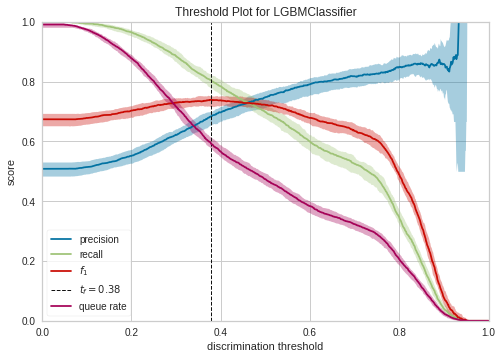

DiscriminationThreshold(ax=<AxesSubplot:title={'center':'Threshold Plot for LGBMClassifier'}, xlabel='discrimination threshold', ylabel='score'>,
                        force_model=None, model=None)

In [33]:
# Discrimination_threshold
discrimination_threshold(best_estimator, X, y)

In [33]:
# changing the threshold
new_pred_prob = change_threshold_lgbm(X=X, y=y, model=best_estimator, n_splits=10, thresh=0.6)

####### Bussines Metrics #######


Increased precision: 0.25
Price Increased in: 2510.0
Percentual of Price increassing: 5.02


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.70      0.88      0.78       496
           1       0.84      0.63      0.72       504

    accuracy                           0.75      1000
   macro avg       0.77      0.75      0.75      1000
weighted avg       0.77      0.75      0.75      1000



In [34]:
# Retraining over all data

def retrain_lightGBM(X, learning_rate, min_child_samples, n_estimators, num_leaves):


    print('> Iniciando Treinamento...')

    cleaning_pipeline = Pipeline(steps=[('preproc', PreProcessingTransformer())])

    pipeline = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                               ('totalpress', TotalPressureTransformer()),
                               ('catpress', CatBloodPressureTransformer())
                               ])

    ct = ColumnTransformer([('numerical',MyRobustScalerTransformer(), ['height','weight', 'ap_hi', 'ap_lo', 'imc', 'total_pressure']),
                           ('categorical',OneHotEncoder(drop='first'), ['gender','cholesterol', 'gluc', 'smoke', 'alco', 'active','cat_bloodpressure','cat_Dwarfism'])])


    pipeline_final = Pipeline(steps= [('geral',pipeline),
                                      ('num_cat', ct),
                                      ('model', lgb.LGBMClassifier(learning_rate=learning_rate , 
                                                                   min_child_samples=min_child_samples, 
                                                                   n_estimators=n_estimators, 
                                                                   num_leaves=num_leaves))])


    data = cleaning_pipeline.fit_transform(X)
    X = data.drop(['cardio'], axis=1)
    y = data['cardio']


    # Fit the model
    print('> Fitting Modelo...')

    model = pipeline_final.fit(X,y)

    return model

model_retrained = retrain_lightGBM(X=train, learning_rate=0.1 ,min_child_samples=10 , n_estimators=100 ,num_leaves=10)


# Dumping the retrrained Pipeline
with open('../models/lgbm_pipe_retrained.pkl', 'wb') as f:
     pickle.dump(model_retrained, f)

> Iniciando Treinamento...
> Fitting Modelo...


## 7.4 CatBoost Pipeline

In [25]:
# CatBoost
def train_catBoost(X, n_iter, n_splits=10):

    print('> Iniciando Treinamento...')
    cleaning_pipeline = Pipeline(steps=[('preproc', PreProcessingTransformer())])

    pipeline = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                               ('totalpress', TotalPressureTransformer()),
                               ('catpress', CatBloodPressureTransformer())
                               ])

    ct = ColumnTransformer([('numerical',MyRobustScalerTransformer(), ['height','weight', 'ap_hi', 'ap_lo']),
                           ('categorical',OneHotEncoder(drop='first'), ['gender','cholesterol', 'gluc', 'smoke', 'alco', 'active','cat_bloodpressure','cat_Dwarfism'])
                           ])


    pipeline_final = Pipeline(steps= [('geral',pipeline),
                                      ('num_cat', ct),
                                      ('model', CatBoostClassifier(
                                                            n_estimators=100,
                                                            depth=6,
                                                            l2_leaf_reg=0.0,
                                                            bagging_temperature=1,
                                                            early_stopping_rounds=100,
                                                            loss_function='Logloss',
                                                            eval_metric='Accuracy',
                                                            verbose=False))])


    data = cleaning_pipeline.fit_transform(X)
    X = data.drop(['cardio'], axis=1)
    y = data['cardio']


    # Fit the random search model
    print('> Fitting Modelo...')

    # cross-validação
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

    acc = []
    kappa = []
    precision = []
    for linhas_treino, linhas_valid in skf.split(X, y):

        X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
        y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

        pipeline_final.fit(X_treino, y_treino)
        pred = pipeline_final.predict(X_valid)
        accuracy = accuracy_score(y_valid, pred)
        Kappa =  cohen_kappa_score(y_valid, pred)
        Precision = precision_score(y_valid, pred)
        acc.append(accuracy)
        kappa.append(Kappa)
        precision.append(Precision)

    print('####### Bussines Metrics #######')

    print('\n')
    acc_inc = np.mean(acc) - 0.50
    prc_inc = round((acc_inc/0.05)*500, 2)
    print(f'Increased accuracy: {round(acc_inc,2)}')
    print(f'Price Increased in: {prc_inc}')
    print(f'Percentual of Price increassing: {round((prc_inc/500),2)}')
    print('\n')

    print('####### Machine Learning Metrics #######')
    print(f'Accuracy médio: {np.mean(acc)}')
    print(f'Accuracy Desvio Padrão: {np.std(acc)}')

    print('\n')

    print(f'kappa médio: {np.mean(kappa)}')
    print(f'kappa Desvio Padrão: {np.std(kappa)}')

    print('\n')

    print(f'Precision médio: {np.mean(precision)}')
    print(f'Precision Desvio Padrão: {np.std(precision)}')

    print('\n')

    print(classification_report(y_valid, pred))
    return pipeline_final

model_cat = train_catBoost(X=train, n_iter=5)

> Iniciando Treinamento...
> Fitting Modelo...
####### Bussines Metrics #######


Increased accuracy: 0.23
Price Increased in: 2280.69
Percentual of Price increassing: 4.56


####### Machine Learning Metrics #######
Accuracy médio: 0.7280688470113261
Accuracy Desvio Padrão: 0.007107690134947862


kappa médio: 0.45611780026867005
kappa Desvio Padrão: 0.014222549354331988


Precision médio: 0.7668268446933968
Precision Desvio Padrão: 0.00691825785639988


              precision    recall  f1-score   support

           0       0.69      0.80      0.74      3494
           1       0.76      0.64      0.70      3492

    accuracy                           0.72      6986
   macro avg       0.73      0.72      0.72      6986
weighted avg       0.73      0.72      0.72      6986



### 7.4.1 Interpreting the Model

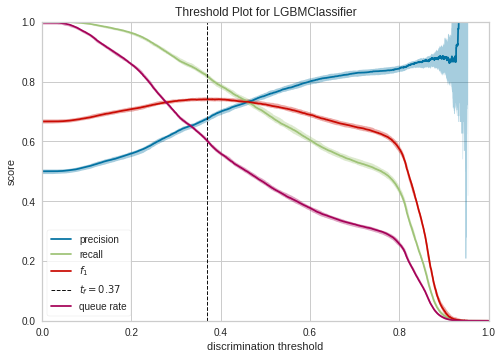

DiscriminationThreshold(ax=<AxesSubplot:title={'center':'Threshold Plot for LGBMClassifier'}, xlabel='discrimination threshold', ylabel='score'>,
                        force_model=None, model=None)

In [70]:
# Discrimination_threshold
discrimination_threshold(model_lgbm, X, y)

In [32]:
# changing the threshold
new_pred_prob = change_threshold_lgbm(X=X, y=y, model=model_cat , n_splits=10, thresh=0.6)

####### Bussines Metrics #######


Increased precision: 0.22
Price Increased in: 2210.0
Percentual of Price increassing: 4.42


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.67      0.86      0.75       496
           1       0.81      0.58      0.68       504

    accuracy                           0.72      1000
   macro avg       0.74      0.72      0.72      1000
weighted avg       0.74      0.72      0.72      1000



In [75]:
def train_catBoost_stats(X, y):

    print('> Iniciando Treinamento...')

    # Transfomer para os dados de Teste
    transfomer = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                                 ('totalpress', TotalPressureTransformer()),
                                 ('catpress', CatBloodPressureTransformer()),
                                 ('scaler', MyRobustScalerTransformer())])

    # Transformando os dados de Teste
    xtreino = transfomer.fit_transform(X)

    # Criando Modelo
    model = CatBoostClassifier(early_stopping_rounds=100,
                               loss_function='Logloss',
                               eval_metric='Accuracy',
                               verbose=False)

    # Fit the random search model
    print('> Fitting Modelo...')
    model.fit(xtreino, y)

    print('> Treinamento realizado...')

    res = model.calc_feature_statistics(xtreino, y,
                                        feature=1,
                                        plot=True)

model_cat = train_catBoost_stats(X=Xtrain, y=ytrain)

> Iniciando Treinamento...
> Fitting Modelo...
> Treinamento realizado...


In [77]:
# Processo de Treinamento
def train_catBoost_viz(X, y, evalX, evaly):

    print('> Iniciando Treinamento...')

    # Transfomer para os dados de Teste
    transfomer = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                                 ('totalpress', TotalPressureTransformer()),
                                 ('catpress', CatBloodPressureTransformer()),
                                 ('scaler', MyRobustScalerTransformer())])




    # Criando o Pipeline de Treino
    pipeline = Pipeline(steps=[('feateng', FeatureEngineeringTransformer()),
                               ('totalpress', TotalPressureTransformer()),
                               ('catpress', CatBloodPressureTransformer()),
                               ('scaler', MyRobustScalerTransformer()),
                               ('model', CatBoostClassifier(early_stopping_rounds=100,
                                                            loss_function='Logloss',
                                                            eval_metric='Recall',
                                                            verbose=False))])


    # Transformando os dados de Teste
    xteste = transfomer.fit_transform(evalX)


    # Fit the random search model
    print('> Fitting Modelo...')
    pipeline.fit(X, y, model__plot=True, model__eval_set=(xteste, evaly))

    print('> Treinamento realizado...')
    return pipeline

model_cat = train_catBoost_viz(X=Xtrain, y=ytrain, evalX=Xtest, evaly=ytest)

> Iniciando Treinamento...
> Fitting Modelo...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

> Treinamento realizado...


## 8.0 API_Predictions

In our example the prediction was class 0, therefore no heart diseases in this case.

In [60]:
# Example Data
test_data = train.sample()

# Tunnig into a json
df_json = test_data.to_json(orient='records')
df_json

'[{"id":34477,"age":20609,"gender":2,"height":160,"weight":60.0,"ap_hi":140,"ap_lo":90,"cholesterol":1,"gluc":1,"smoke":0,"alco":0,"active":1,"cardio":1}]'

### 8.1 API_Predictions - Normal Threshold

In [61]:
# url = 'http://0.0.0.0:5000/predict'
url = 'https://pa001-app.herokuapp.com/predict'
data = df_json
header = {'Content-type': 'application/json'}

# Request
r = requests.post(url=url, data=data, headers=header)
print(r.status_code)
r.json()

200


[{'id': 34477,
  'age': 20609,
  'gender': 2,
  'height': 160,
  'weight': 60.0,
  'ap_hi': 140,
  'ap_lo': 90,
  'cholesterol': 1,
  'gluc': 1,
  'smoke': 0,
  'alco': 0,
  'active': 1,
  'cardio': 1,
  'prediction': 0}]

### 8.2 API_Predictions - Impossing Threshold (0.6)

In [62]:
# url = 'http://0.0.0.0:5000/predict_thresh'
url = 'https://pa001-app.herokuapp.com/predict_thresh'
data = df_json
header = {'Content-type': 'application/json'}

# Request
r = requests.post(url=url, data=data, headers=header)
print(r.status_code)
r.json()

200


[{'id': 34477,
  'age': 20609,
  'gender': 2,
  'height': 160,
  'weight': 60.0,
  'ap_hi': 140,
  'ap_lo': 90,
  'cholesterol': 1,
  'gluc': 1,
  'smoke': 0,
  'alco': 0,
  'active': 1,
  'cardio': 1,
  'prediction': 0.0}]